In [287]:
%load_ext autoreload
%autoreload 2

from constructions1D import *
from constructions2D import *
from geometricMultiGrid import *
from plt_utils import *

from scipy.sparse.linalg import spsolve,gmres, LinearOperator
from scipy.sparse import eye
from scipy.linalg import norm
import numpy as np

from functools import partial

import matplotlib.pyplot as plt
from ipywidgets import interact,widgets 

plt.rc('axes', grid=True)
plt.rc('legend', loc='best')
plt.style.use('ggplot')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 1.2 1D model problem

## (b)

In [253]:
def helmholtz1D_model(sigma=-600, omega = 2/3,n=64,recursion_depth=5,iterations =50):
    f = pointsource_half(n)
    u_approx = guessv0(n)
    u_exact = spsolve(helmholtz1D(n,sigma),f)
    errors = [u_exact-u_approx] 
    for _ in range(iterations):
        u_approx = geoVcycle(
            mat = partial(helmholtz1D,sigma=sigma), 
            f= f, 
            u = u_approx, 
            nu1=1,
            nu2=1,
            relax=partial(wjacobi,omega= omega), 
            restrict=simple_restrict, 
            interpolate=simple_interpolate, 
            recursion_depth=recursion_depth)
        errors.append(u_exact-u_approx)
    return errors

@interact(
    log2n=widgets.IntSlider(min=1, max=12, value=6),
    sigma_real=widgets.FloatSlider(min=-10**3, max=10**3, step=1, value=-600,description=r"R(sig)$"),
    sigma_complex=widgets.FloatSlider(min=-10**3, max=10**3, step=1, value=-300,description=r"im(sig)"),
    omega_real=widgets.FloatSlider(min=-1, max=1, step=0.1, value=2/3,description=r"R(omega)"),
    omega_complex=widgets.FloatSlider(min=-1, max=1, step=0.01, value=-0.1,description=r"Im(omega)")
)
def tmp(log2n,sigma_real,sigma_complex,omega_real,omega_complex):
    n = int(2**log2n)
    sigma = complex(sigma_real,sigma_complex)
    omega = complex(omega_real,omega_complex)
    errors = helmholtz1D_model(sigma=sigma,omega=omega,n=n,recursion_depth=20,iterations =50)
    norms = np.array([norm(e) for e in errors])
    plt.plot(norms)
    plt.xlabel("Iteration")
    plt.ylabel("norm(error)")
    plt.yscale("log")
    plt.title("Convergence of V-cycles")
    plt.show()

interactive(children=(IntSlider(value=6, description='log2n', max=12, min=1), FloatSlider(value=-600.0, descri…

## (D)

In [255]:
@interact(
    n=widgets.IntSlider(min=1, max=200, value=32),
    sigma_real=widgets.FloatSlider(min=-10**3, max=10**3, step=1, value=0),
    sigma_complex=widgets.FloatSlider(min=-10**4, max=10**4, step=10, value=0)
)
def plt_eigen_H(sigma_real,sigma_complex, n):
    sigma = complex(sigma_real,sigma_complex)
    title = rf'eigenvalues of $H$ with $n={n},\sigma = {sigma}$'
    Hs = [helmholtz1D(n*j, sigma) for j in [1,2]]
    labels = [f'$H{j}$' for j in [n,2*n]]
    ys = np.array([eigen_helmhotz1D(n,k,sigma) for k in range(1,n)])
    xs = np.linspace(0,1,len(ys))
    plt.plot(xs,ys.real,label="formula.real",linestyle="--",linewidth=3)
    plt.plot(xs,ys.imag,label="formula.imag",linestyle="--",linewidth=3)
    plt_eigen(Hs,labels,title)


interactive(children=(FloatSlider(value=0.0, description='sigma_real', max=1000.0, min=-1000.0, step=1.0), Flo…

# 1.3
## (b)

In [258]:

def G(theta,sigma,omega,n):
    return  1-omega+ 2*(omega * n**2)*np.cos(theta)/(2*n**2+sigma)

@interact(
    n=widgets.IntSlider(min=1, max=100, value=64),
    sigma_real=widgets.FloatSlider(min=-10**3, max=10**3, step=1, value=-600),
    sigma_complex=widgets.FloatSlider(min=-10**4, max=10**4, step=1, value=0),
    omega_real=widgets.FloatSlider(min=-1, max=1, step=0.1, value=2/3),
    omega_complex=widgets.FloatSlider(min=-1, max=1, step=0.1, value=0)
)
def plt_eigen_Rw_Gtheta(sigma_real,sigma_complex, omega_real,omega_complex, n):
    sigma = complex(sigma_real,sigma_complex)
    omega = complex(omega_real,omega_complex)
    theta = np.linspace(-np.pi, np.pi, n)
    Gs = G(theta, sigma, omega, n)
    Gs_sorted = np.array(sorted(Gs, key=lambda x: np.abs(
        x)*(0 if x.real == 0 else x.real/np.abs(x.real))))
    xs = np.linspace(0, 1, len(Gs))
    plt_R_im_abs(xs,Gs,r"$G(\theta)$")
    plt_R_im_abs(xs,Gs_sorted,r"sorted $G(\theta)$","--")
    title = rf'$G(\theta)$ and eigenvalues of $R_\omega$ with  $n={n},\sigma = {sigma}, \omega = {omega}$'
    plt_eigen([Romega(n, sigma,omega)],[r"$R_\omega$"],title)



interactive(children=(FloatSlider(value=-600.0, description='sigma_real', max=1000.0, min=-1000.0, step=1.0), …

## (d)

In [5]:
G(0,-600,2/3,64)

1.0526870389884089

# 1.4
## (a)

In [261]:
def s(j,n):return j if j<=n else n-j
def a(n,k):return 1-np.sin(k*np.pi/(4*n))**2  
n = 2**6
ys = [simple_restrict(wave_basis_1D(2*n,j))/(wave_basis_1D(n,s(j,n))*a(n,j)+0.00001) for j in range(2*n)]
plt_vecs(ys,[f"component wise division between wk"]*len(ys))

interactive(children=(IntSlider(value=0, description='i', max=127), Output()), _dom_classes=('widget-interact'…

In [262]:
n = 2**6
# lin_boundary is on
reconstruction_errors = [simple_interpolate(simple_restrict(wk),lin_boundary=True)-wk for wk in [wave_basis_1D_complex(n,k) for k in range(n)]]

@interact(
    k=widgets.IntSlider(value=0, min=0, max=len(reconstruction_errors) - 1, description="i")
)
def plt_reconstruction_error(k):
    plt_vec(reconstruction_errors[k], f"reconstruction_error for w_{k}")
    for j in [1,2]:
        plt.subplot(1, 2, j)
        bound = (k)**2*np.pi**2/(6*n**2)
        plt.plot(range(n),np.ones(n)*bound, color ="green",label="error estimate",linestyle ="--")
        plt.plot(range(n),- np.ones(n)*bound, color="green",linestyle= "--")
        plt.legend(loc="upper right")
        plt.ylim(-5*bound-0.0001,5*bound+0.0001)
    plt.show()

interactive(children=(IntSlider(value=0, description='i', max=63), Output()), _dom_classes=('widget-interact',…

## (b)

In [266]:
@interact(
    n=widgets.IntSlider(min=1,max=1000,step=1,value=64),
    sigma_real=widgets.FloatSlider(min=-10**3, max=10**3, step=1, value=-600),
    sigma_complex=widgets.FloatSlider(min=-10**3, max=10**3, step=1, value=0)
)
def plt_rho(n,sigma_real,sigma_complex):
    sigma = complex(sigma_real,sigma_complex)
    ks = np.linspace(1,n,n*10)
    eggs = [1-eigen_helmhotz1D(2*n,k,sigma)/eigen_helmhotz1D(n,k,sigma) for k in ks]
    eggs_aggressive = [1-eigen_helmhotz1D(4*n,k,sigma)/eigen_helmhotz1D(n,k,sigma) for k in ks]
    plt.plot(ks,eggs, label= "1k 10 points",linewidth=4)
    plt.plot(ks,eggs_aggressive, label= "1k 10 points aggressive",linestyle="--",linewidth=2)
    ks = np.linspace(1,n,n)
    eggs = [1-eigen_helmhotz1D(2*n,k,sigma)/eigen_helmhotz1D(n,k,sigma) for k in ks]
    plt.plot(ks,eggs, label="1k 1 point")
    plt.legend()
    max_index = np.argmax(np.abs(eggs[1:20]))
    plt.title(r"$\rho_{k}$ vs k")
    print("Index of maximum value in eggs: ", max_index)  
    plt.show()


interactive(children=(IntSlider(value=64, description='n', max=1000, min=1), FloatSlider(value=-600.0, descrip…

# 2.1

## (b)

C:\Users\isido\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\scipy\sparse\linalg\_dsolve\linsolve.py:168: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  warn('spsolve requires A be CSC or CSR matrix format',


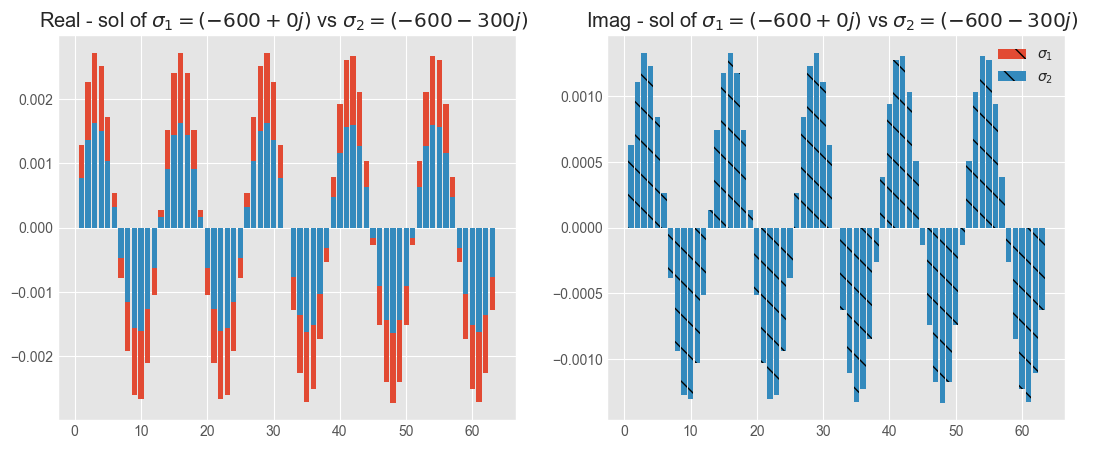

In [277]:
n =64
sigma1 = complex(-600,0)
sigma2 = complex(-600,-300)
# f = pointsource_half(n)
f = wave_basis_1D(n,10)
u_exact1 = spsolve(helmholtz1D(n,sigma1),f)
u_exact2 = spsolve(helmholtz1D(n,sigma2),f)
title = rf"sol of $\sigma_1 = {sigma1}$ vs $\sigma_2 = {sigma2}$  "
plt_vec(u_exact1,label=r"$\sigma_{1}$")
plt_vec(u_exact2,title,reuse=True,label=r"$\sigma_{2}$")
plt.legend()
plt.show()

## (d)


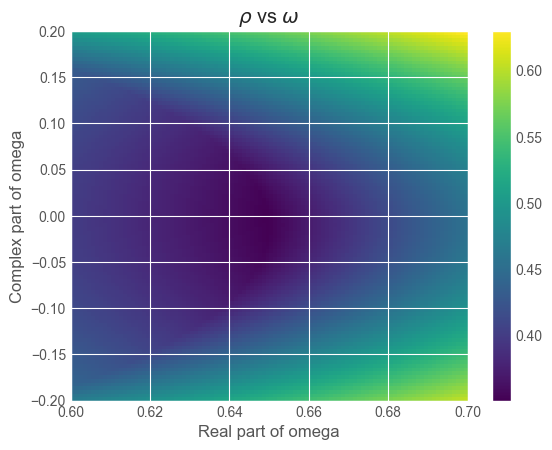

The omega that reaches the minimum is: 0.6494949494949495 + -0.002020202020202033j, rho = 0.3505108723645395


In [282]:

def G(theta, sigma, omega, n):
    return 1 - omega + 2 * (omega * n**2) * np.cos(theta) / (2 * n**2 + sigma)

def max_G(sigma, n, resolution=100):
    omega_real = np.linspace(0.6, 0.7, resolution)
    omega_complex = np.linspace(-0.2, 0.2, resolution)
    max_values = np.zeros((resolution, resolution), dtype=np.float64)

    for i, real_part in enumerate(omega_real):
        for j, complex_part in enumerate(omega_complex):
            omega = complex(real_part, complex_part)
            thetas = np.linspace(np.pi/2, np.pi, 40)
            values = [np.abs(G(theta, sigma, omega, n)) for theta in thetas]
            max_values[j, i] = np.max(values)

    return omega_real, omega_complex, max_values

sigma = complex(-600, -300)
n = 64
omega_real, omega_complex, max_values = max_G(sigma, n)

plt.imshow(max_values, extent=[0.6, 0.7, -0.2, 0.2], origin='lower', cmap='viridis', aspect='auto')
# plt.grid(False)
plt.colorbar()
plt.xlabel('Real part of omega')
plt.ylabel('Complex part of omega')
plt.title(r"$\rho$ vs $\omega$")
plt.show()

min_value = np.min(max_values)
min_indices = np.where(max_values == min_value)
min_omega_real = omega_real[min_indices[1][0]]
min_omega_complex = omega_complex[min_indices[0][0]]

print(f"The omega that reaches the minimum is: {min_omega_real} + {min_omega_complex}j, rho = {min_value}")

# 2.4
## (a)

In [283]:
def helmholtz2D_model(sigma=complex(-600,-300), omega = 2/3,n=64,recursion_depth=3,iterations =12):
    f = pointsource_half2D(n)
    u_approx = np.zeros((n-1)**2) 
    u_exact = spsolve(helmholtz2D(n,sigma),f)
    errors = [u_exact-u_approx] 
    for _ in range(iterations):
        u_approx = geoVcycle(
            mat = (partial(helmholtz2D,sigma=sigma)), 
            f= f, 
            u = u_approx, 
            nu1=1,
            nu2=1,
            relax=partial(wjacobi,omega= omega), 
            restrict=simple_restrict2D, 
            interpolate=simple_interpolate2D, 
            recursion_depth=recursion_depth,
            dimensions =2)
        errors.append(u_exact-u_approx)
    return errors

errors = helmholtz2D_model(n=128,iterations = 50)
plt_vecs2D(errors,[f"errors after {i} Vcycles" for i in range(len(errors))])

interactive(children=(IntSlider(value=0, description='i', max=50), Output()), _dom_classes=('widget-interact',…

## (b)

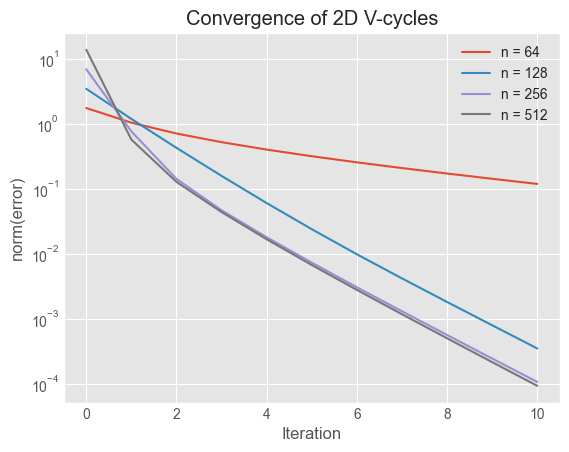

In [244]:
for n in [64,128,256,512]:
    errors = helmholtz2D_model(n=n,iterations = 10) 
    norms =  [norm(e) for e in errors] 
    plt.plot(norms, label=f"n = {n}")

plt.yscale("log")
plt.xlabel("Iteration")
plt.ylabel("norm(error)")
plt.title("Convergence of 2D V-cycles")
plt.grid(True)
plt.legend()
plt.show()


# 2.5
## (b)

In [284]:

def simple_interpolate_aggressive(u):
    return simple_interpolate(simple_interpolate(u))

def simple_restrict_aggressive(u):
    return simple_restrict(simple_restrict(u))

def helmholtz1D_model_aggressive(sigma=complex(-600,-300), omega = 2/3,log4n=3,recursion_depth=200,iterations =50):
    n = int(4**log4n)
    f = pointsource_half(n)
    u_approx = guessv0(n)
    u_exact = spsolve(helmholtz1D(n,sigma),f)
    errors = [u_exact-u_approx] 
    for _ in range(iterations):
        u_approx = geoVcycle(
            mat = partial(helmholtz1D,sigma=sigma), 
            f= f, 
            u = u_approx, 
            nu1=1,
            nu2=1,
            relax=partial(wjacobi,omega= omega), 
            restrict=simple_restrict_aggressive, 
            interpolate=simple_interpolate_aggressive, 
            recursion_depth=recursion_depth)
        errors.append(u_exact-u_approx)
    return errors

C:\Users\isido\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\scipy\sparse\linalg\_dsolve\linsolve.py:168: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  warn('spsolve requires A be CSC or CSR matrix format',


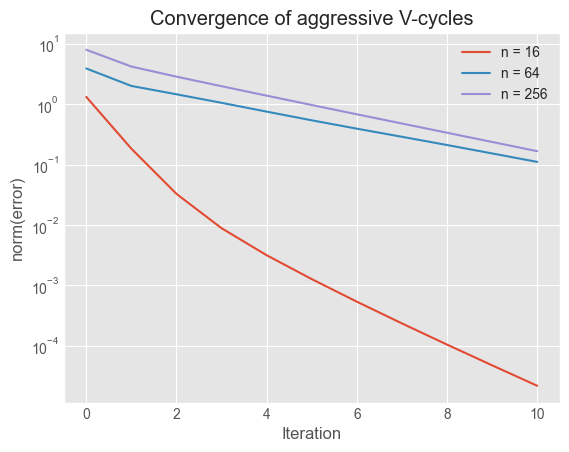

In [289]:
for log4n in range(2,5):
    errors = helmholtz1D_model_aggressive(
        log4n=log4n,
        sigma=complex(-600,-600),
        iterations = 10,
        recursion_depth=log4n-1) 
    norms =  [norm(e) for e in errors] 
    plt.plot(norms, label=f"n = {int(4**log4n)}")

plt.yscale("log")
plt.xlabel("Iteration")
plt.ylabel("norm(error)")
plt.title("Convergence of aggressive V-cycles")
plt.legend()
plt.show()

In [290]:
errors = helmholtz1D_model_aggressive(
    sigma=complex(-600,-600),
    log4n=4,
    iterations = 50,
    recursion_depth=3) 
plt_vecs(errors,[f"errors after {i} aggressive Vcycles" for i in range(len(errors))])

interactive(children=(IntSlider(value=0, description='i', max=50), Output()), _dom_classes=('widget-interact',…

In [298]:
def GMRES_norms(n,pre_con=None,restart=20,max_iter =1,label=""):
    if not(pre_con):
        pre_con = eye((n-1)**2)

    pr_norms = []
    def callback(x):
        pr_norms.append(x)

    n = 128

    sol, info = gmres(
        A = helmholtz2D(n,-600), 
        b= pointsource_half2D(n),
        M = pre_con, 
        restart = restart,
        maxiter=max_iter,
        callback= callback,
        callback_type ="pr_norm")
    plt.plot(pr_norms,label=label)
    plt.yscale('log')
    plt.title("GMRES pre, norm residuals")
    plt.xlabel("Iteration")
    plt.ylabel("norm(residual)")

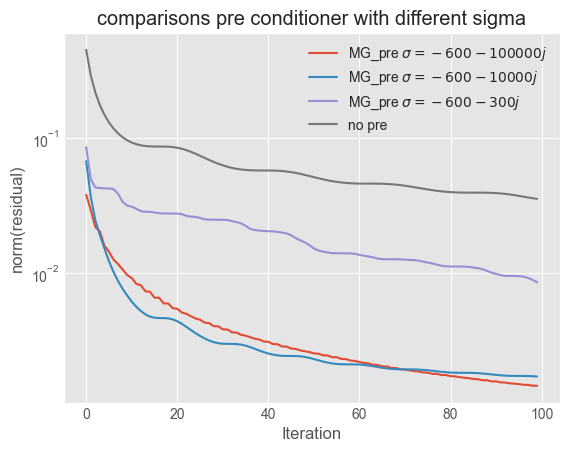

In [301]:
n = 128
def Helmholtz2D_MG_pre_Vcycle(n,sigma):
    return LinearOperator(((n-1)**2,(n-1)**2),lambda u: geoVcycle(
            mat = (partial(helmholtz2D,sigma=sigma)), 
            f= pointsource_half2D(n), 
            u=u,
            nu1=1,
            nu2=1,
            relax=partial(wjacobi,omega= 2/3), 
            restrict=simple_restrict2D, 
            interpolate=simple_interpolate2D, 
            recursion_depth=100,
            dimensions =2
))

rsts = 100
miter = 1
GMRES_norms(n,Helmholtz2D_MG_pre_Vcycle(n,complex(-600,-100000)),rsts,miter,label=r"MG_pre $\sigma = -600-100000j$")
GMRES_norms(n,Helmholtz2D_MG_pre_Vcycle(n,complex(-600,-10000)),rsts,miter,label=r"MG_pre $\sigma = -600-10000j$")
GMRES_norms(n,Helmholtz2D_MG_pre_Vcycle(n,complex(-600,-300)),rsts,miter,label=r"MG_pre $\sigma = -600-300j$")
GMRES_norms(n,None,rsts,miter,label="no pre")
plt.title("comparisons pre conditioner with different sigma")
plt.legend()
plt.show()